In [1]:
import datetime
print(f"last edit: {datetime.datetime.now()}")

last edit: 2025-08-16 07:04:38.005922


In [2]:
# Download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-16 07:04:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-16 07:04:38 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [4]:
!nvidia-smi

Sat Aug 16 07:04:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Download data (food vision)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-08-16 07:04:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  75.7MB/s    in 19s     

2025-08-16 07:05:01 (83.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_clas

In [9]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [10]:
# Create checkoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

In [13]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps= int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.0090 - loss: 4.7166 - val_accuracy: 0.0241 - val_loss: 4.6086
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 156ms/step - accuracy: 0.0132 - loss: 4.6514 - val_accuracy: 0.0334 - val_loss: 4.5541
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0146 - loss: 4.6083 - val_accuracy: 0.0448 - val_loss: 4.5017
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.0217 - loss: 4.5584 - val_accuracy: 0.0535 - val_loss: 4.4531
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.0271 - loss: 4.5104 - val_accuracy: 0.0625 - val_loss: 4.4057


In [16]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.0443 - loss: 4.4405


[4.438307762145996, 0.04399999976158142]

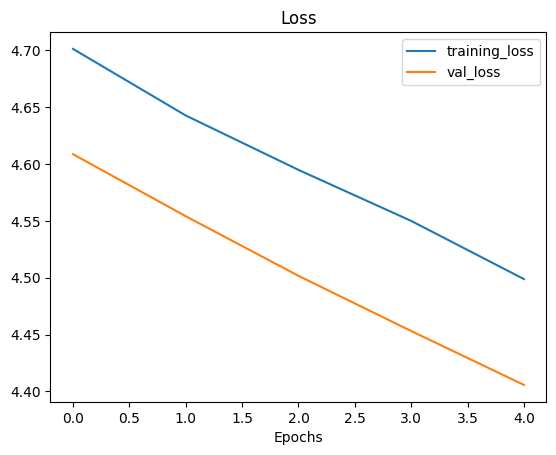

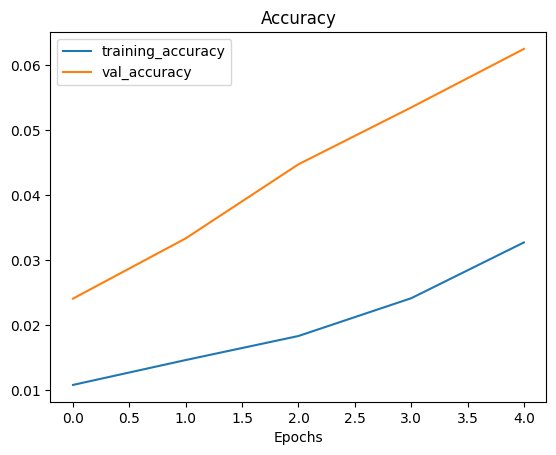

In [17]:
plot_loss_curves(history_all_classes_10_percent)

In [18]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [20]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [21]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [22]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.1026 - loss: 4.2532 - val_accuracy: 0.3318 - val_loss: 3.3845
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.3380 - loss: 3.3108 - val_accuracy: 0.4584 - val_loss: 2.6120
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.4371 - loss: 2.6906 - val_accuracy: 0.5111 - val_loss: 2.2007
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.5006 - loss: 2.3238 - val_accuracy: 0.5267 - val_loss: 1.9989
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.5330 - loss: 2.0988 - val_accuracy: 0.5339 - val_loss: 1.8951
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5543 - loss: 1.9465 - val_accuracy: 0.5442 - val_loss: 1.8129


In [23]:
results_all_10_classes_fine_tune = model.evaluate(test_data)
results_all_10_classes_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5505 - loss: 1.7504


[1.6626135110855103, 0.5686732530593872]

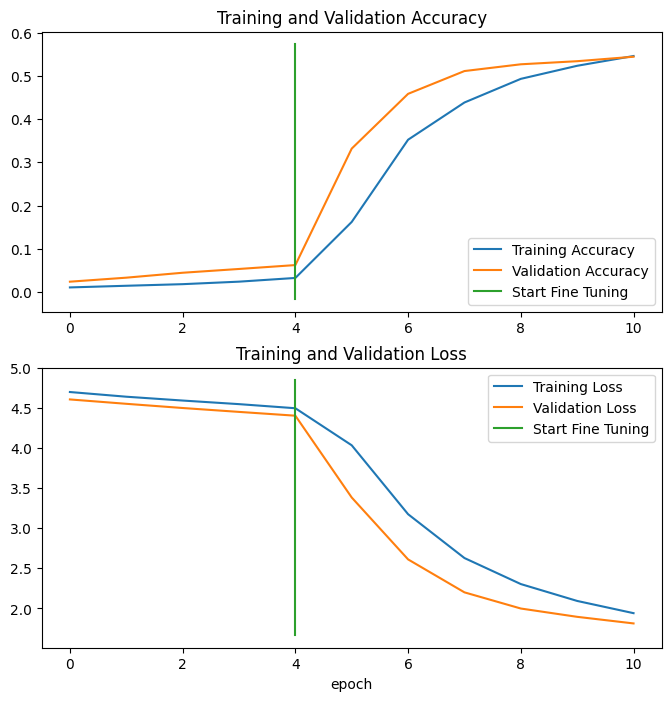

In [24]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

##**Save our trained model**

In [30]:
import os

# Check if drive is already mounted
if os.path.exists('/content/drive/MyDrive'):
    print("✅ Google Drive is already mounted!")
else:
    from google.colab import drive
    drive.mount('/content/drive')

✅ Google Drive is already mounted!


In [31]:
import os

# Save your model to Google Drive
model_save_dir = "/content/drive/MyDrive/Dive into deep learning with tensorflow/models/"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_save_dir, "101_food_classes_10_percent_model.keras")
model.save(model_path)

# Verify the save worked
if os.path.exists(model_path):
    print(f"✅ Model saved successfully to: {model_path}")
    print(f"File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

    # List all files in the directory
    print(f"\nFiles in the models directory:")
    for file in os.listdir(model_save_dir):
        print(f"  - {file}")

else:
    print("❌ Model file not found after saving")

✅ Model saved successfully to: /content/drive/MyDrive/Dive into deep learning with tensorflow/models/101_food_classes_10_percent_model.keras
File size: 23.72 MB

Files in the models directory:
  - 101_food_classes_10_percent_model.keras


In [32]:
# Create a small text file to trigger sync
sync_file = "/content/drive/MyDrive/Dive into deep learning with tensorflow/models/sync_test.txt"
with open(sync_file, 'w') as f:
    f.write("This file was created to trigger Drive sync")

print("Sync file created. Check your Google Drive now.")

Sync file created. Check your Google Drive now.


In [33]:
import os

model_path = "/content/drive/MyDrive/Dive into deep learning with tensorflow/models/101_food_classes_10_percent_model.keras"

# Double-check file details
if os.path.exists(model_path):
    print(f"✅ File exists in Colab")
    print(f"Full path: {model_path}")
    print(f"File size: {os.path.getsize(model_path)} bytes")
    print(f"Directory contents:")

    dir_path = os.path.dirname(model_path)
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        size = os.path.getsize(item_path) if os.path.isfile(item_path) else "DIR"
        print(f"  - {item} ({size} bytes)")

✅ File exists in Colab
Full path: /content/drive/MyDrive/Dive into deep learning with tensorflow/models/101_food_classes_10_percent_model.keras
File size: 24867591 bytes
Directory contents:
  - 101_food_classes_10_percent_model.keras (24867591 bytes)
  - sync_test.txt (43 bytes)


In [2]:
from google.colab import files

# Download the model file directly to your computer
model_path = "/content/drive/MyDrive/Dive into deep learning with tensorflow/models/101_food_classes_10_percent_model.keras"
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Evaluating the performance of the model**

In [5]:
import tensorflow as tf
import keras
import numpy as np

# Download and unzip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
!unzip -q 06_101_food_class_10_percent_saved_big_dog_model.zip

# Load as inference-only layer in Keras 3
model_path = "06_101_food_class_10_percent_saved_big_dog_model"
model = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')

print("✅ Model loaded successfully as TFSMLayer!")

# Test the model
test_input = np.random.random((1, 224, 224, 3)).astype(np.float32)  # Make sure it's float32
prediction = model(test_input)

# Handle dictionary output - can't use .shape directly on dict
print(f"Prediction type: {type(prediction)}")
print(f"Prediction keys: {list(prediction.keys())}")

# Extract the actual prediction tensor
for key, value in prediction.items():
    print(f"Key: '{key}', Shape: {value.shape}")

# Get the main prediction (usually the first one)
main_prediction = list(prediction.values())[0]
print(f"✅ Main prediction shape: {main_prediction.shape}")

# Show predicted class if it's classification
predicted_class = tf.argmax(main_prediction, axis=1)
print(f"Predicted class: {predicted_class.numpy()}")

--2025-08-16 07:49:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.3’

06_101_food_class_1 100%[===================>]  44.59M   177MB/s    in 0.3s    

2025-08-16 07:49:37 (177 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.3’ saved [46760742/46760742]

replace __MACOSX/._06_101_food_class_10_percent_saved_big_dog_model? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


✅ Model loaded successfully as TFSMLayer!
Prediction type: <class 'dict'>
Prediction keys: ['dense_8']
Key: 'dense_8', Shape: (1, 101)
✅ Main prediction shape: (1, 101)
Predicted class: [64]
